In [9]:
from codecs import xmlcharrefreplace_errors
from doctest import NORMALIZE_WHITESPACE

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import seaborn as sns
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split,RandomizedSearchCV
#划分数据集
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures
#预处理
from sklearn.feature_selection import mutual_info_classif,SelectKBest
#特征选择
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#逻辑回归
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,precision_recall_curve,auc
#性能评估
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



In [10]:
dataframe = pd.read_csv(r'D:\BMW_Car_Sales_Classification.csv')

##了解数据的详细情况

print('数据大致信息',dataframe.describe())
print('数据形状',dataframe.shape)
print('缺失值',dataframe.isnull().sum())



数据大致信息                Year  Engine_Size_L     Mileage_KM      Price_USD  Sales_Volume
count  50000.000000   50000.000000   50000.000000   50000.000000  50000.000000
mean    2017.015700       3.247180  100307.203140   75034.600900   5067.514680
std        4.324459       1.009078   57941.509344   25998.248882   2856.767125
min     2010.000000       1.500000       3.000000   30000.000000    100.000000
25%     2013.000000       2.400000   50178.000000   52434.750000   2588.000000
50%     2017.000000       3.200000  100388.500000   75011.500000   5087.000000
75%     2021.000000       4.100000  150630.250000   97628.250000   7537.250000
max     2024.000000       5.000000  199996.000000  119998.000000   9999.000000
数据形状 (50000, 11)
缺失值 Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
S

In [11]:

cate_col = ['Model','Region','Color','Fuel_Type','Transmission','Sales_Classification']
for col in cate_col:
    print(f'\n 数据集的特殊值:{col}',dataframe[col].unique())
    print(f'相应数量 {col} \n',dataframe[col].value_counts())

print("\n目标分布:\n ", dataframe['Sales_Classification'].value_counts(normalize = True))

print("\n重复项：",dataframe.duplicated().sum())


 数据集的特殊值:Model ['5 Series' 'i8' 'X3' '7 Series' 'M5' '3 Series' 'X1' 'M3' 'X5' 'i3' 'X6']
相应数量 Model 
 Model
7 Series    4666
i3          4618
i8          4606
3 Series    4595
5 Series    4592
X1          4570
X3          4497
X5          4487
M5          4478
X6          4478
M3          4413
Name: count, dtype: int64

 数据集的特殊值:Region ['Asia' 'North America' 'Middle East' 'South America' 'Europe' 'Africa']
相应数量 Region 
 Region
Asia             8454
Middle East      8373
North America    8335
Europe           8334
Africa           8253
South America    8251
Name: count, dtype: int64

 数据集的特殊值:Color ['Red' 'Blue' 'Black' 'Silver' 'White' 'Grey']
相应数量 Color 
 Color
Red       8463
Silver    8350
Grey      8348
White     8304
Black     8273
Blue      8262
Name: count, dtype: int64

 数据集的特殊值:Fuel_Type ['Petrol' 'Hybrid' 'Diesel' 'Electric']
相应数量 Fuel_Type 
 Fuel_Type
Hybrid      12716
Petrol      12550
Electric    12471
Diesel      12263
Name: count, dtype: int64

 数据集的特殊值:Transmission ['

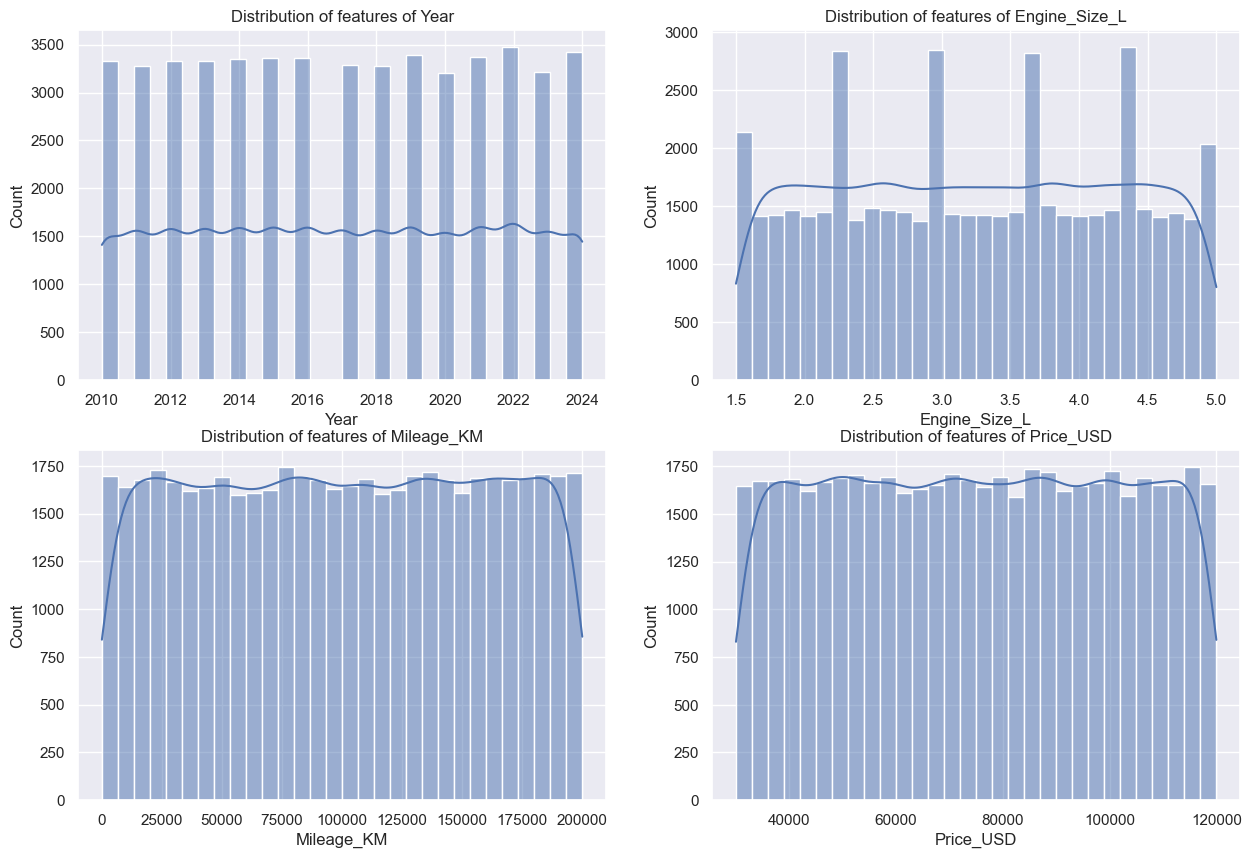

In [12]:
#进行可视化

#画数值型数据的特征分布直方图，看看数据是否有偏态，或者是否过度集中。
sns.set_theme()
plt.figure(figsize=(15,10))
numerical_cols = ['Year','Engine_Size_L','Mileage_KM','Price_USD']
for i , col in enumerate(numerical_cols , 1):
    plt.subplot(2,2,i)
    sns.histplot(dataframe[col], kde = True , bins = 30)
    plt.title(f'Distribution of features of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout
plt.show()


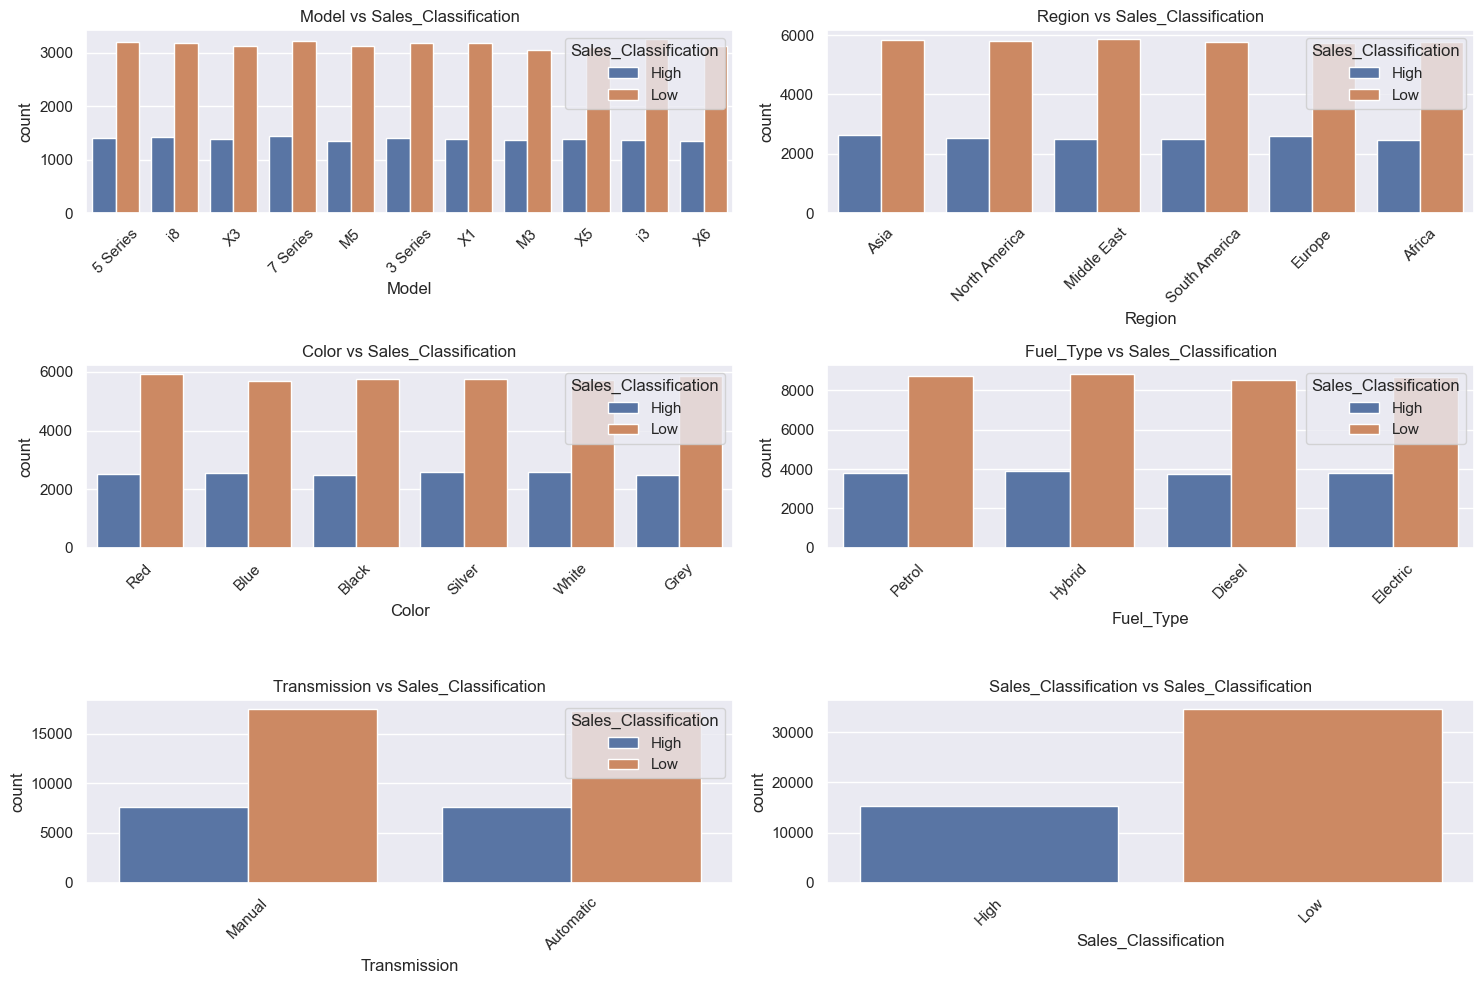

In [13]:
#画分类特征的柱状图，看看特征与目标值的关系。
plt.figure(figsize=(15,10))
for i ,col in enumerate(cate_col , 1):
    plt.subplot(3,2,i)
    sns.countplot(data = dataframe , x = col , hue = 'Sales_Classification')
    plt.title(f'{col} vs Sales_Classification')
    plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

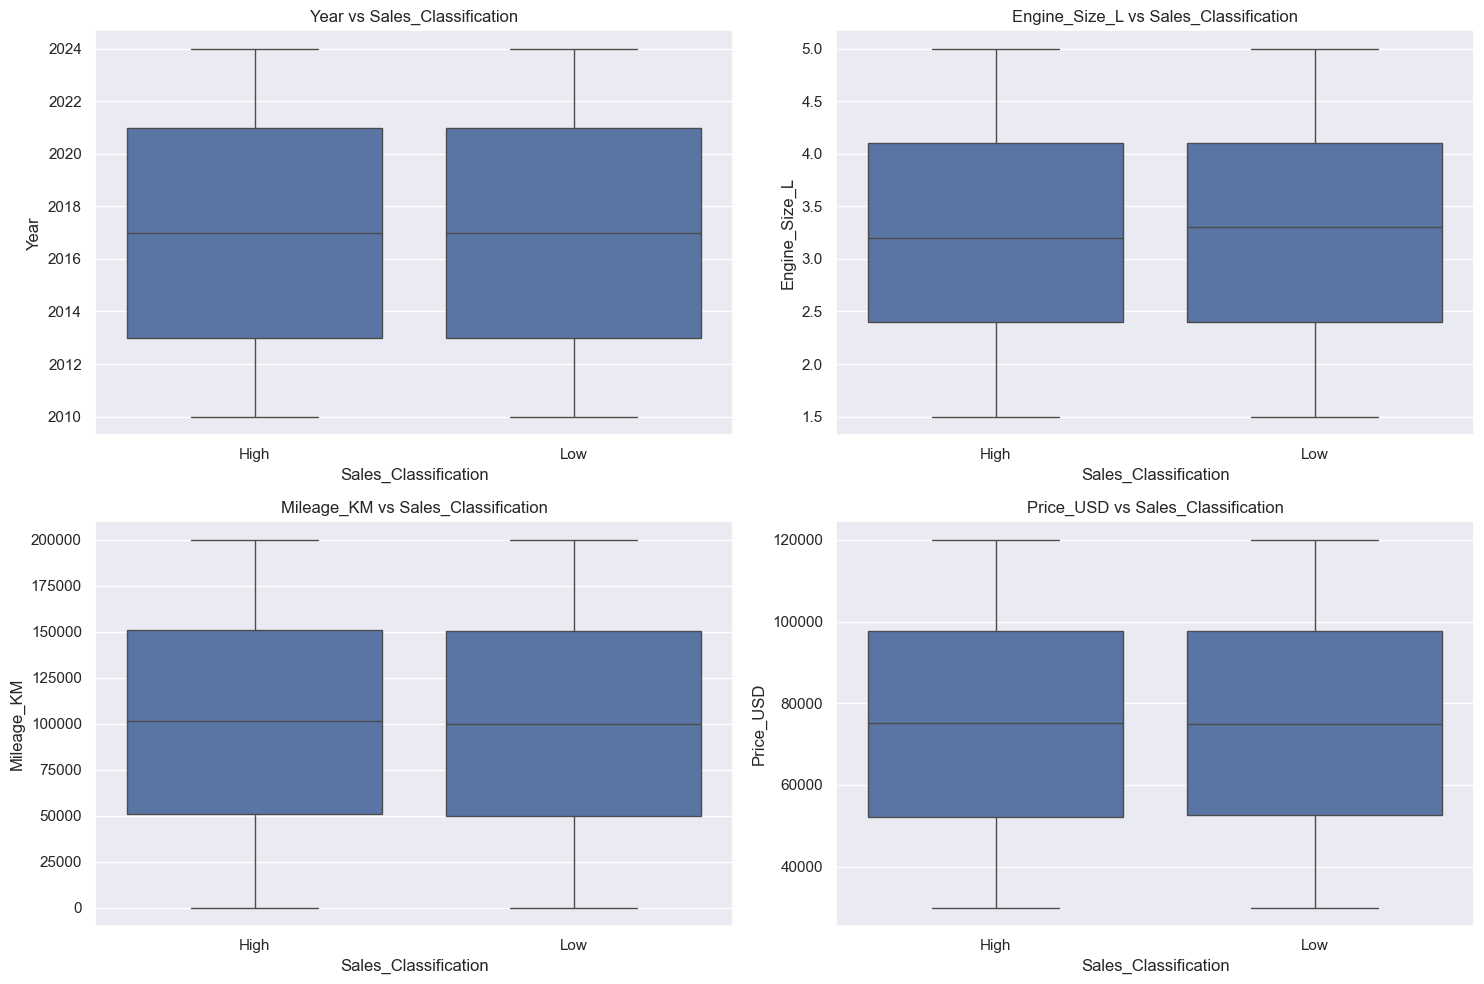

In [45]:
#画箱线图，比较高销售量和低销售量在数值上的分布差异
plt.figure(figsize=(15,10))
for i ,col in enumerate(numerical_cols , 1):
    plt.subplot(2,2,i)
    sns.boxplot(data = dataframe , x ='Sales_Classification', y = col)
    plt.title(f'{col} vs Sales_Classification')
plt.tight_layout()
plt.show()



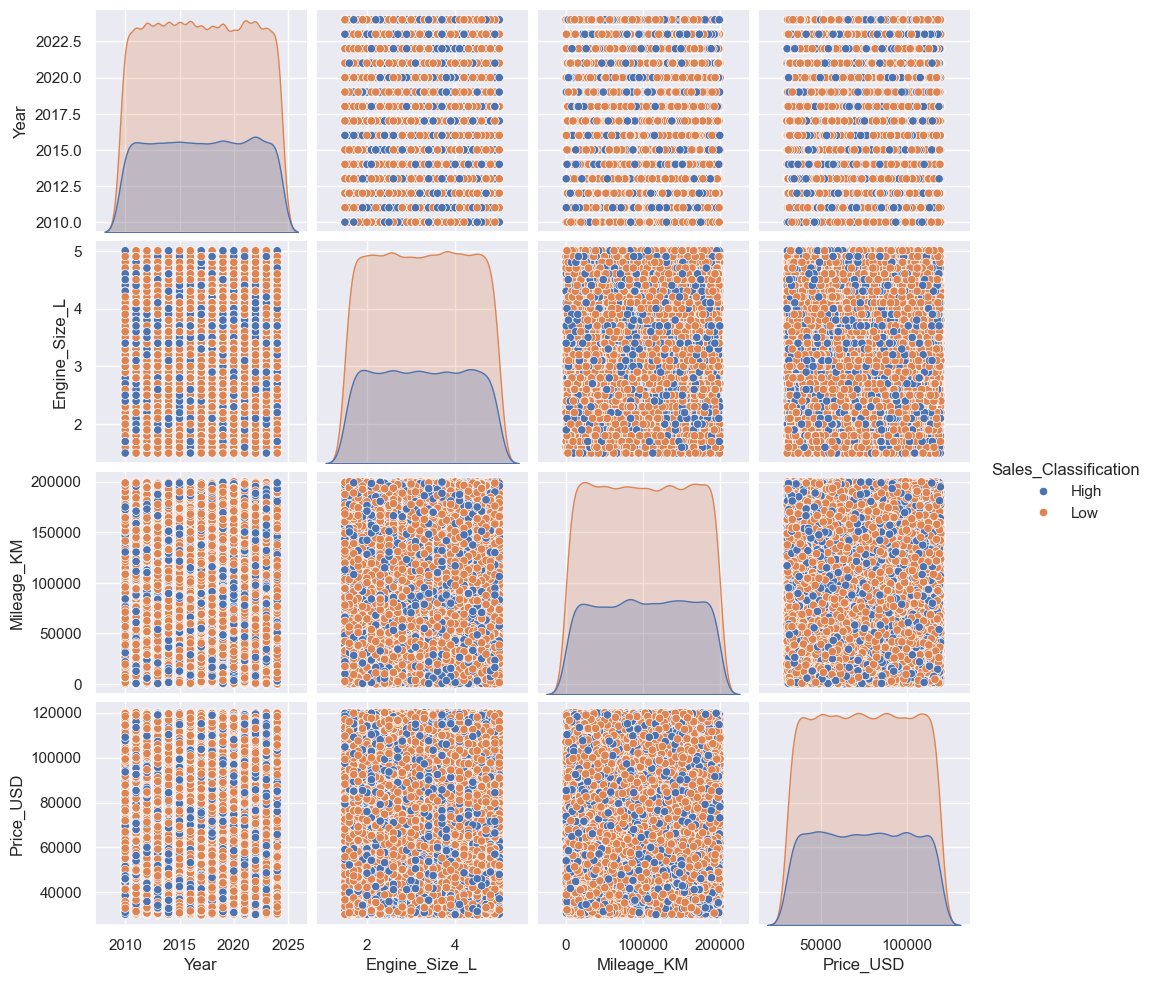

In [15]:
#这个三电图是为了看看特征组合之前是否可以区别，像这种都混在一起的就不行了。
sns.pairplot(dataframe[numerical_cols + ['Sales_Classification']], hue = 'Sales_Classification', diag_kind = 'kde')
plt.show()

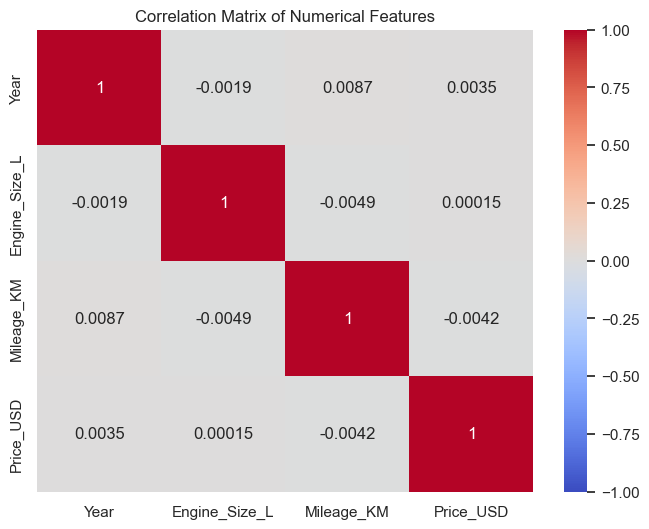

In [16]:
plt.figure(figsize=(8, 6))
corr_matrix = dataframe[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [17]:
new_dataframe = dataframe.drop(['Sales_Volume'], axis = 1)
X = new_dataframe.drop('Sales_Classification', axis = 1)
y = new_dataframe['Sales_Classification'].map({'High':1, 'Low':0})
categorical_col = ['Model','Region','Color','Fuel_Type','Transmission']


In [18]:
numerical_cols = ['Year','Engine_Size_L','Mileage_KM','Price_USD']
preprocesser = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols ),
        ('cates', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_col)
    ]  
)
X_preprocessed = preprocesser.fit_transform(X)

In [19]:
encodee_cates_cols = preprocesser.named_transformers_['cates'].get_feature_names_out(categorical_col)
all_cols = numerical_cols + list(encodee_cates_cols)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns = all_cols)

In [20]:
print(X_preprocessed_df.head(5))

       Year  Engine_Size_L  Mileage_KM  Price_USD  Model_3 Series  \
0 -0.234876       0.250548    0.887814   0.911817             0.0   
1 -0.928611      -1.632377    0.368717   0.160951             0.0   
2  1.152595       1.241561   -1.541504   1.470514             0.0   
3  1.615085      -1.533276   -1.260805  -0.540950             0.0   
4  0.690105      -1.136871    0.376656  -0.966867             0.0   

   Model_5 Series  Model_7 Series  Model_M3  Model_M5  Model_X1  Model_X3  \
0             1.0             0.0       0.0       0.0       0.0       0.0   
1             0.0             0.0       0.0       0.0       0.0       0.0   
2             1.0             0.0       0.0       0.0       0.0       0.0   
3             0.0             0.0       0.0       0.0       0.0       1.0   
4             0.0             1.0       0.0       0.0       0.0       0.0   

   Model_X5  Model_X6  Model_i3  Model_i8  Region_Africa  Region_Asia  \
0       0.0       0.0       0.0       0.0        

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size = 0.2, random_state = 42, stratify = y)

In [22]:
poly = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X[numerical_cols])
poly_cols = poly.get_feature_names_out(numerical_cols)
X_poly_df = pd.DataFrame(X_poly, columns = poly_cols)

In [23]:
X_engineerd = X.copy()
X_engineerd['Price_per_Engine_Size'] = X['Price_USD'] / X['Engine_Size_L']
X_engineerd['Milege_per_Year'] = X['Mileage_KM'] / (2025 - X['Year'])
X_engineerd['Is_Newer'] = (X['Year'] >= 2020).astype(int)

In [24]:
X_engineerd = pd.concat([X_engineerd.drop(columns=numerical_cols), X_poly_df], axis = 1)
X_engineerd = X_engineerd.loc[:, ~X_engineerd.columns.duplicated()]

In [25]:
engineered_numerical_cols = [col for col in X_engineerd.columns if col not in categorical_col]


preprocesser_engineerd = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), engineered_numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_col)
    ]
)
X_engineerd_preprocessed = preprocesser_engineerd.fit_transform(X_engineerd)

In [26]:
encoded_cat_cols = preprocesser_engineerd.named_transformers_['cat'].get_feature_names_out(categorical_col)
all_engineered_cols = engineered_numerical_cols + list(encoded_cat_cols)



In [27]:
X_engineerd_preprocessed_df = pd.DataFrame(X_engineerd_preprocessed, columns = all_engineered_cols)
X_train_eng, X_test_eng,y_train, y_test = train_test_split(X_engineerd_preprocessed_df, y, test_size = 0.2, random_state = 42, stratify=y)

In [28]:
# selector = SelectKBest(mutual_info_classif, k = 20)
# X_train_selected = selector.fit_transform(X_train_eng,y_train)
# X_test_selected = selector.transform(X_test_eng)

In [29]:
# selected_indices = selector.get_support(indices=True)
# selected_features = [all_engineered_cols[i] for i in selected_indices]

In [30]:
# print(selected_features)

In [31]:
class_weights = {0: 1.0, 1:2.28}

In [32]:
log_reg = LogisticRegression(random_state=42, class_weight=class_weights, max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42, class_weight=class_weights, n_estimators=100)
xgb_clf = XGBClassifier(random_state=42, scale_pos_weight=2.28)

In [33]:
log_reg.fit(X_train_eng, y_train)
rf_clf.fit(X_train_eng, y_train)
xgb_clf.fit(X_train_eng, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [34]:
y_pred_log = log_reg.predict(X_test_eng)
y_pred_rf = rf_clf.predict(X_test_eng)
y_pred_xgb = xgb_clf.predict(X_test_eng)


In [35]:
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))
print("\nXGBoost Report:\n", classification_report(y_test, y_pred_xgb))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.69      0.50      0.58      6951
           1       0.30      0.49      0.37      3049

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.57      0.50      0.52     10000


Random Forest Report:
               precision    recall  f1-score   support

           0       0.70      0.99      0.82      6951
           1       0.35      0.01      0.02      3049

    accuracy                           0.69     10000
   macro avg       0.52      0.50      0.42     10000
weighted avg       0.59      0.69      0.57     10000


XGBoost Report:
               precision    recall  f1-score   support

           0       0.69      0.59      0.64      6951
           1       0.29      0.39      0.33      3049

    accuracy                           0.53     10000
   macro avg       0.49      0.49      0.49     10000
wei

In [36]:
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Logistic Regression Confusion Matrix:
 [[3490 3461]
 [1550 1499]]

Random Forest Confusion Matrix:
 [[6906   45]
 [3025   24]]

XGBoost Confusion Matrix:
 [[4117 2834]
 [1867 1182]]


In [37]:
##根据数据来看，还是xgb适合一点，所以后续就用xgb，我们调整一下参数看看。

In [38]:
param_dist = {  
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [2.0, 2.28, 2.5]
}


In [39]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [40]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=3,
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [41]:
random_search.fit(X_train_eng, y_train)


best_xgb = random_search.best_estimator_

y_pred_best = best_xgb.predict(X_test_eng)
y_pred_proba_best = best_xgb.predict_proba(X_test_eng)[:, 1]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [42]:
print("Best Parameters:", random_search.best_params_)
print("\nXGBoost Tuned Report:\n", classification_report(y_test, y_pred_best))
print("\nXGBoost Tuned Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
y_pred_proba_best = best_xgb.predict_proba(X_test_eng)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_best)
print(f"\nXGBoost Tuned ROC AUC: {roc_auc}")

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 2.28, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 0.8}

XGBoost Tuned Report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73      6951
           1       0.30      0.22      0.25      3049

    accuracy                           0.60     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.57      0.60      0.59     10000


XGBoost Tuned Confusion Matrix:
 [[5380 1571]
 [2379  670]]

XGBoost Tuned ROC AUC: 0.4913664734337948


In [43]:
mi = mutual_info_classif(X_train_eng, y_train)
pd.Series(mi, index=all_engineered_cols).sort_values(ascending=False)


Region_Asia                 0.005758
Year Price_USD              0.004907
Is_Newer                    0.004528
Model_M5                    0.003875
Fuel_Type_Electric          0.003748
Color_Black                 0.003593
Model_M3                    0.003498
Transmission_Manual         0.003176
Model_i3                    0.003173
Fuel_Type_Petrol            0.002924
Region_Africa               0.002575
Transmission_Automatic      0.002286
Model_5 Series              0.002160
Year                        0.001989
Price_USD                   0.001714
Model_X5                    0.001554
Color_Silver                0.001408
Color_Blue                  0.001318
Color_White                 0.001207
Model_i8                    0.001168
Year Mileage_KM             0.001137
Price_per_Engine_Size       0.001097
Model_3 Series              0.000897
Model_X1                    0.000738
Model_X3                    0.000167
Fuel_Type_Hybrid            0.000128
Year Engine_Size_L          0.000000
M

In [44]:
print("总结：\n"
      "经过多次调整，ROC_AUC 值仍然在0.5徘徊，则可见Confusion Matrix，\n"
      "Random Forest Confusion Matrix，XGBoost Confusion Matrix\n"
      "这三个模型都无法有效区分High/Low销售，因为数据特征与目标关联度太弱。\n"
      "Confusion Matrix 本身显示了预测严重偏向多数类，正类几乎无法捕捉。\n"
      "现有特征 + 现有标签下，Logistic Regression、Random Forest、XGBoost 的可用性几乎可以排除。\n"
      "建议：\n"
      "1、增加更强的特征来提高数据集的可读性\n"
      "2、可以尝试一下少数类增强，但预计效果不会很好\n")


总结：
经过多次调整，ROC_AUC 值仍然在0.5徘徊，则可见Confusion Matrix，
Random Forest Confusion Matrix，XGBoost Confusion Matrix
这三个模型都无法有效区分High/Low销售，因为数据特征与目标关联度太弱。
Confusion Matrix 本身显示了预测严重偏向多数类，正类几乎无法捕捉。
现有特征 + 现有标签下，Logistic Regression、Random Forest、XGBoost 的可用性几乎可以排除。
建议：
1、增加更强的特征来提高数据集的可读性
2、可以尝试一下少数类增强，但预计效果不会很好

